In [1]:
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import numpy as np

from scipy.signal import fftconvolve

from pulse2percept import electrode2currentmap as e2cm

import skcuda.fft as cu_fft

In [2]:
N = 4096 * 16

x = np.asarray(np.random.rand(N), np.float32)
xf = np.fft.fft(x)
y = np.real(np.fft.ifft(xf))

In [3]:
x_gpu = gpuarray.to_gpu(x)
xf_gpu = gpuarray.empty(N//2+1, np.complex64)
plan_forward = cu_fft.Plan(x_gpu.shape, np.float32, np.complex64)
cu_fft.fft(x_gpu, xf_gpu, plan_forward)

In [4]:
y_gpu = gpuarray.empty_like(x_gpu)
plan_inverse = cu_fft.Plan(x_gpu.shape, np.complex64, np.float32)
cu_fft.ifft(xf_gpu, y_gpu, plan_inverse, True)
print('Success status: ', np.allclose(y, y_gpu.get(), atol=1e-6))

Success status:  True


In [5]:
print('Testing in-place fft..')
x = np.asarray(np.random.rand(N) + 1j * np.random.rand(N), np.complex64)
x_gpu = gpuarray.to_gpu(x)

Testing in-place fft..


In [6]:
plan = cu_fft.Plan(x_gpu.shape, np.complex64, np.complex64)
cu_fft.fft(x_gpu, x_gpu, plan)

cu_fft.ifft(x_gpu, x_gpu, plan, True)

print('Success status: ', np.allclose(x, x_gpu.get(), atol=1e-6))

Success status:  True


In [7]:
tsample = 5e-6
dur = 0.5

In [8]:
# %timeit fftconvolve(signal, gamma3, mode='full')

In [9]:
from scipy import fftpack

In [10]:
fftpack.next_fast_len(41)

45

In [11]:
# original p2p signal
signal = np.random.rand(int(np.round(dur / tsample)))
signal_copy = signal

# zero-pad
fshape = fftpack.next_fast_len(signal.shape[-1])

len1 = int((fshape - signal.shape[-1]) / 2)
len2 = fshape - len1 - signal.shape[-1]

signal_padded = np.concatenate((np.zeros(len1), signal, np.zeros(len2)))

In [12]:
signal_padded.shape

(100000,)

In [13]:
fshape

100000

In [14]:
signal = np.asarray(signal, np.float32)

signal_gpu = gpuarray.to_gpu(signal)
signal_out_gpu = gpuarray.empty(signal.shape[-1]//2 + 1, np.complex64)
plan = cu_fft.Plan(signal_gpu.shape, np.float32, np.complex64)

%timeit cu_fft.fft(signal_gpu, signal_out_gpu, plan)

The slowest run took 6.21 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 36 µs per loop


In [15]:
tau3 = 26.25/1000
t = np.arange(0, 8*tau3, tsample)
gamma3 = e2cm.gamma(3, tau3, t)
gamma3_copy = gamma3

len1 = int((fshape - gamma3.shape[-1]) / 2)
len2 = fshape - len1 - gamma3.shape[-1]

gamma3 = np.concatenate((np.zeros(len1), gamma3, np.zeros(len2)))

gamma3 = np.asarray(gamma3, np.float32)

In [16]:
gamma3.shape

(100000,)

In [17]:
cu_fft.fft?

In [18]:
gamma3_gpu = gpuarray.to_gpu(gamma3)
gamma3_out_gpu = gpuarray.empty(gamma3.shape[-1]//2 + 1, np.complex64)
plan = cu_fft.Plan(gamma3_gpu.shape, np.float32, np.complex64)

%timeit cu_fft.fft(gamma3_gpu, gamma3_out_gpu, plan)

The slowest run took 7.04 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 35.6 µs per loop


In [19]:
signal_out_gpu.get()

array([  5.00125234e+04 +0.j        ,   2.96747360e+01+53.14291763j,
        -4.11043854e+01-44.55865479j, ...,  -1.49682693e+02-54.80981445j,
        -1.99830246e+01-15.26214218j,   1.19435547e+02 +0.j        ], dtype=complex64)

In [20]:
cu_fft.fft(gamma3_gpu, gamma3_out_gpu, plan)
gamma3_out_gpu.get()

array([  1.97249000e+05 +0.00000000e+00j,
        -1.60452906e+05 -6.34436797e+04j,
         7.53606406e+04 +8.99284453e+04j, ...,
         1.75781250e-01 -9.37500000e-02j,
         5.46875000e-02 +1.93359375e-01j,  -2.10937500e-01 +0.00000000e+00j], dtype=complex64)

In [21]:
signal_out_gpu.shape

(50001,)

In [22]:
gamma3_out_gpu.shape

(50001,)

In [23]:
signal_out_gpu = signal_out_gpu * gamma3_out_gpu

In [24]:
signal_out_gpu

array([  9.86492006e+09 +0.00000000e+00j,
        -1.38981538e+06 -1.04096100e+07j,
         9.09437688e+05 -7.05442200e+06j, ...,
        -3.14498310e+01 +4.39821482e+00j,
         1.85825658e+00 -4.69855356e+00j,  -2.51934357e+01 +0.00000000e+00j], dtype=complex64)

In [25]:
inv_gpu = gpuarray.empty(signal.shape[-1], np.float32)
plan_inverse = cu_fft.Plan(signal_out_gpu.shape, np.complex64, np.float32)
cu_fft.ifft(signal_out_gpu, inv_gpu, plan_inverse, True)

In [26]:
inv_gpu.shape

(100000,)

In [27]:
inv_gpu

array([  9.85395781e+04,   9.85394141e+04,   9.85393984e+04, ...,
         1.72411437e-05,  -6.98655717e-11,  -5.11287399e-05], dtype=float32)

In [28]:
cpu_out = fftconvolve(signal_copy, gamma3_copy)

print('Success status: ', np.allclose(cpu_out[0:inv_gpu.shape[-1]], inv_gpu.get(), atol=1e-6))

Success status:  False


In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

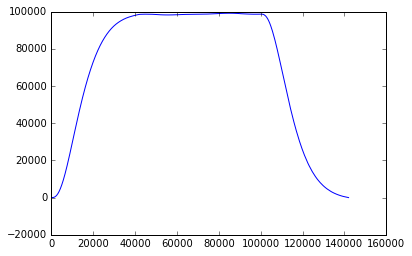

In [30]:
plt.plot(cpu_out)

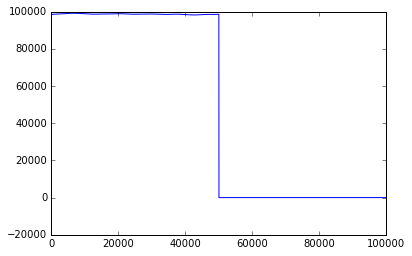

In [31]:
plt.plot(inv_gpu.get())